# Random Forest

In [104]:
import yfinance as yf
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
%matplotlib inline

ticker= "googl"
stock_data = yf.download(ticker, start="2008-01-04", end="2022-01-27")

[*********************100%***********************]  1 of 1 completed


In [105]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-04,340.185181,340.820831,327.827820,328.828827,328.828827,10708880
2008-01-07,327.297302,331.471466,318.993988,324.949951,324.949951,12793993
2008-01-08,326.826813,330.310303,315.815826,316.156158,316.156158,10667522
2008-01-09,315.335327,326.997009,311.566559,326.926941,326.926941,13465921
2008-01-10,322.827820,328.928925,320.375366,323.688690,323.688690,12655732


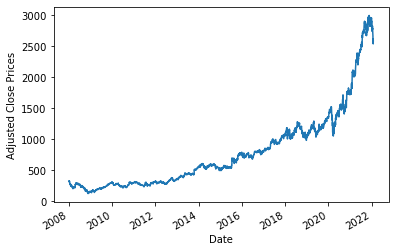

In [106]:
stock_data['Adj Close'].plot()
plt.ylabel("Adjusted Close Prices")
plt.show()

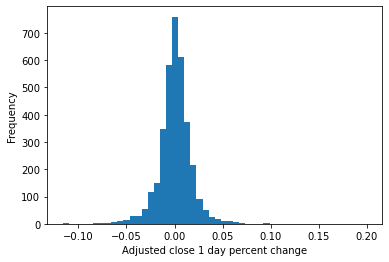

In [107]:
stock_data['Adj Close'].pct_change().plot.hist(bins=50)
plt.xlabel("Adjusted close 1 day percent change")
plt.show()

In [108]:
feature_names = []
for n in [14, 30, 50, 200]:
    stock_data['ma' + str(n)] = talib.SMA(stock_data['Adj Close'].values, timeperiod=n)
    stock_data['rsi' + str(n)] = talib.RSI(stock_data['Adj Close'].values, timeperiod=n)

    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

In [109]:
stock_data['Volume_1d_change'] = stock_data['Volume'].pct_change()

volume_features = ['Volume_1d_change']
feature_names.extend(volume_features)

In [110]:
stock_data['5d_future_close'] = stock_data['Adj Close'].shift(-5)
stock_data['5d_close_future_pct'] = stock_data['5d_future_close'].pct_change(5)

In [111]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200,Volume_1d_change,5d_future_close,5d_close_future_pct
Date,,,,,,,,,,,,,,,,,
2008-01-04,340.185181,340.820831,327.827820,328.828827,328.828827,10708880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,319.444458,NaN
2008-01-07,327.297302,331.471466,318.993988,324.949951,324.949951,12793993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.194709,327.237244,NaN
2008-01-08,326.826813,330.310303,315.815826,316.156158,316.156158,10667522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.166209,319.144135,NaN
2008-01-09,315.335327,326.997009,311.566559,326.926941,326.926941,13465921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.262329,308.283295,NaN
2008-01-10,322.827820,328.928925,320.375366,323.688690,323.688690,12655732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.060166,300.695709,NaN


In [112]:
stock_data.dropna(inplace=True)

X = stock_data[feature_names]
y = stock_data['5d_close_future_pct']

train_size = int(0.85 * y.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

In [113]:
grid = {'n_estimators': [200], 'max_depth': [3], 'max_features': [4, 8], 'random_state': [42]}
test_scores = []

rf_model = RandomForestRegressor()

for g in ParameterGrid(grid):
    rf_model.set_params(**g) 
    rf_model.fit(X_train, y_train)
    test_scores.append(rf_model.score(X_test, y_test))

best_index = np.argmax(test_scores)
print(test_scores[best_index], ParameterGrid(grid)[best_index])

-0.004603602279713126 {'random_state': 42, 'n_estimators': 200, 'max_features': 8, 'max_depth': 3}


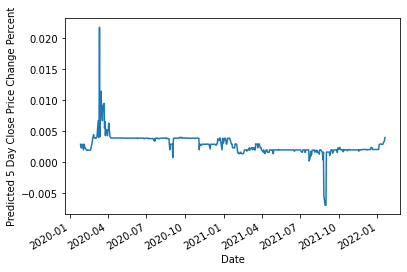

In [114]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

y_pred_series = pd.Series(y_pred, index=y_test.index)
y_pred_series.plot()
plt.ylabel("Predicted 5 Day Close Price Change Percent")
plt.show()

In [115]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.028562585052397057
Mean Squared Error: 0.001569082138123055
Root Mean Squared Error: 0.03961164144696676


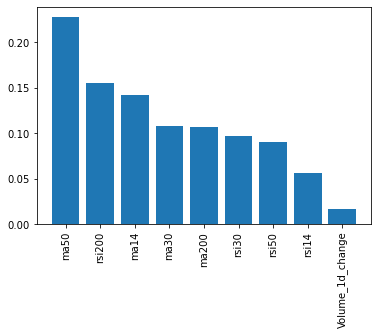

In [116]:
importances = rf_model.feature_importances_
sorted_index = np.argsort(importances)[::-1]
x_values = range(len(importances))
labels = np.array(feature_names)[sorted_index]
plt.bar(x_values, importances[sorted_index], tick_label=labels)
plt.xticks(rotation=90)
plt.show()

In [118]:
print ("accuracy")
rf_model.score(X_train, y_train)

accuracy


0.09730518946731148

## Referencias
https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
https://www.youtube.com/watch?v=-tHCAEZzUhc
https://www.youtube.com/watch?v=VtItg-J6-CI